# Impact of $c_s^2$ on observables

Usual dark energy models assume an effective sound speed of $c_s^2 = 1$. What is the impact of another choice, *e.g.* $c_s^2 = 0$?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["legend.framealpha"] = 0.0

In [7]:
# Cosmological parameters for examples
H0 = 67
omegam = 0.319
omegab = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.07
dark_energy_type = "wcdm"

dark_energy_types = ["desi_pp_mean", "wcdm"]
if dark_energy_type == "desi_pp_mean":
    # DESI DR2 BAO + CMB + Pantheon+ mean
    w0 = -0.838
    wa = -0.62
elif dark_energy_type == "wcdm":
    w0 = -0.8
    wa = 0
else:
    raise Exception(f"Unsupported dark_energy_type {dark_energy_type}; supported values are {dark_energy_types}.")

# Derived parameters
h = H0/100
omegac = omegam - omegab
ombh2 = omegab*h*h
omch2 = omegac*h*h

# k, z grid for power spectrum
ks = np.logspace(-4, -0.9, 200)
redshifts = np.linspace(0, 3, 200)

In [8]:
cases = [
    {"name": "quint",     "label": "$c_s^2 = 1$",     "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1,    "cs2_1": 0},
    {"name": "clust1e-1", "label": "$c_s^2 = 0.1$",   "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-1, "cs2_1": 0},
    {"name": "clust1e-2", "label": "$c_s^2 = 0.01$",  "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-2, "cs2_1": 0},
    {"name": "clust1e-3", "label": "$c_s^2 = 0.001$", "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-3, "cs2_1": 0},
    # {"name": "0to1",  "label": "$c_s^2$ from 0 to 1", "cs2_type": camb.dark_energy.Cs2_PropToW,  "cs2_0": 1 - (-1/wa - 0.001)*w0, "cs2_1": -1/wa - 0.001},
    # {"name": "1to0",  "label": "$c_s^2$ from 1 to 0", "cs2_type": camb.dark_energy.Cs2_PropToW,  "cs2_0": -(1/wa + 0.001)*w0,     "cs2_1": 1/wa + 0.001},
]

def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, WantTransfer=True, w0=w0, wa=wa, dark_energy_model="fluid",
        cs2_type=case["cs2_type"], cs2_0=case["cs2_0"], cs2_1=case["cs2_1"]
    )
    cosmo.set_for_lmax(2000, lens_potential_accuracy=1)
    cosmo.set_matter_power(redshifts=redshifts, kmax=20, silent=True, nonlinear=True)
    results = camb.get_results(cosmo)
    P_lin = results.get_matter_power_interpolator(nonlinear=None).P(redshifts, ks)
    fsigma8 = results.get_fsigma8()
    cl_tt = results.get_lensed_scalar_cls(CMB_unit='muK')[:,0]
    cl_ee = results.get_lensed_scalar_cls(CMB_unit='muK')[:,1]
    cl_te = results.get_lensed_scalar_cls(CMB_unit='muK')[:,3]
    cl_pp = results.get_lens_potential_cls(lmax=2000)[:,0]
    ev    = results.get_redshift_evolution(ks, redshifts, ['delta_cdm', 'delta_tot', 'delta_tot_de']) # NOTE: tot here does not include DE, tot_de does
    rhos  = results.get_background_densities(a=1/(1 + redshifts))
    rho_de    = rhos["de"]
    rho_no_de = rhos["cdm"] + rhos["baryon"] + rhos["neutrino"]
    # rho_no_de = rho_tot - rho_de
    delta_cdm   = ev[:, :, 0]
    delta_no_de = ev[:, :, 1]
    delta_tot   = ev[:, :, 2]
    delta_de = (delta_tot - delta_no_de)*rho_no_de/rho_de
    return {"P_lin": P_lin, "fsigma8": fsigma8, "cl_tt": cl_tt, "cl_ee": cl_ee, "cl_te": cl_te, "cl_pp": cl_pp, "delta_cdm": delta_cdm, "delta_de": delta_de, "rhos": rhos}

data = {}
for case in cases:
    data[case["name"]] = get_observables(case)

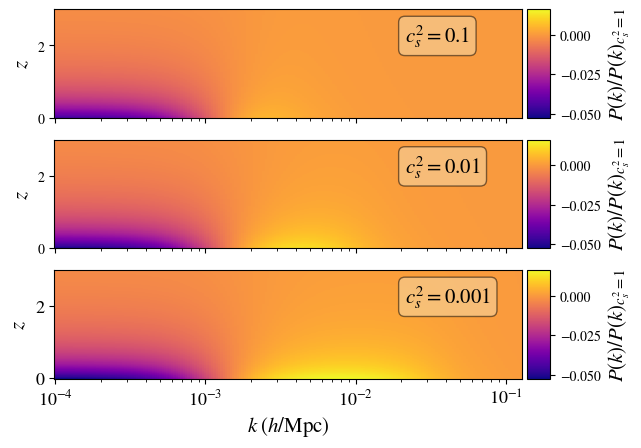

In [15]:
# Plot P(k)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

# Precomputing min and max relative errors for unifying the colormaps in each axis
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
vmin = np.inf
vmax = -np.inf
for ax, case in zip(axs, cases[1:]):
    relative_errors = data[case["name"]]["P_lin"]/data["quint"]["P_lin"] - 1
    vmin = min(vmin, np.amin(relative_errors))
    vmax = max(vmax, np.amax(relative_errors))
norm = Normalize(vmin=vmin, vmax=vmax)

for ax, case in zip(axs, cases[1:]):
    relative_errors = data[case["name"]]["P_lin"]/data["quint"]["P_lin"] - 1
    mesh = ax.pcolormesh(ks, redshifts, relative_errors, cmap="plasma", norm=norm)
    ax.set_xscale('log')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mesh, cax=cax, orientation="vertical")
    cax.set_ylabel(r"$P(k)/P(k)_{c_s^2 = 1}$", fontsize=15)
    ax.set_ylabel(r"$z$", fontsize=15)
    ax.text(0.75, 0.7, case["label"], transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}, fontsize=15)

axs[-1].tick_params(labelsize=13)
axs[-1].set_xlabel(r"$k \; (h/\mathrm{Mpc})$", fontsize=15)
plt.savefig("plots/cs2_impact_pk.pdf", bbox_inches="tight")

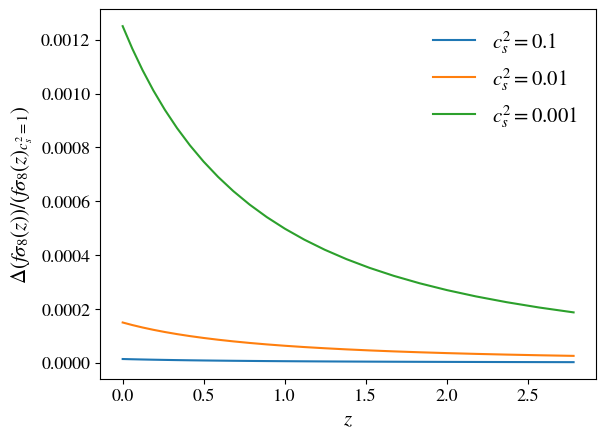

In [8]:
# Plot fractional shift in f\sigma_8
for case in cases:
    if case["name"] == "quint": continue
    plt.plot(redshifts[redshifts < 3], data[case["name"]]["fsigma8"][redshifts < 3]/data["quint"]["fsigma8"][redshifts < 3] - 1, label=case["label"])

plt.tick_params(labelsize=13)
plt.xlabel("$z$", fontsize=15)
plt.ylabel(r"$\Delta(f\sigma_8(z))/(f\sigma_8(z)_{c_s^2=1})$", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("plots/cs2_impact_fsigma8.pdf", bbox_inches="tight")

/tmp/ipykernel_27861/2043509897.py:5: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(ells, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])


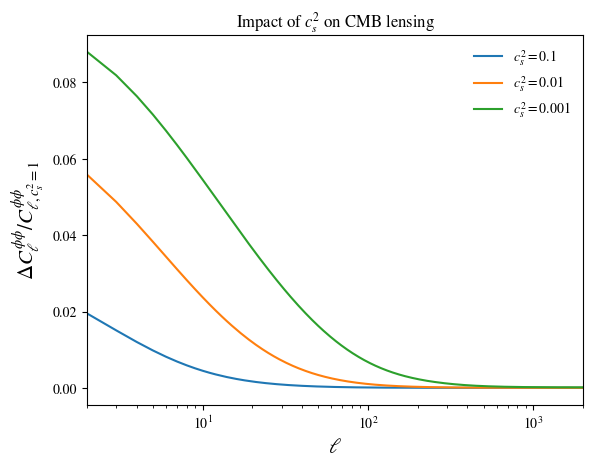

In [5]:
# Plot CMB C_\ell^\phi\phi
ells = np.arange(2001)
for case in cases:
    if case["name"] == "quint": continue
    plt.semilogx(ells, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])

plt.xlim([2, 2000])
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$\Delta C_\ell^{\phi\phi}/C_{\ell, c_s^2=1}^{\phi\phi}$", fontsize=15)
plt.legend()
plt.title("Impact of $c_s^2$ on CMB lensing")
plt.savefig("cs2_impact_cl_phiphi.pdf")

/tmp/ipykernel_27861/79990905.py:5: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(ells, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])


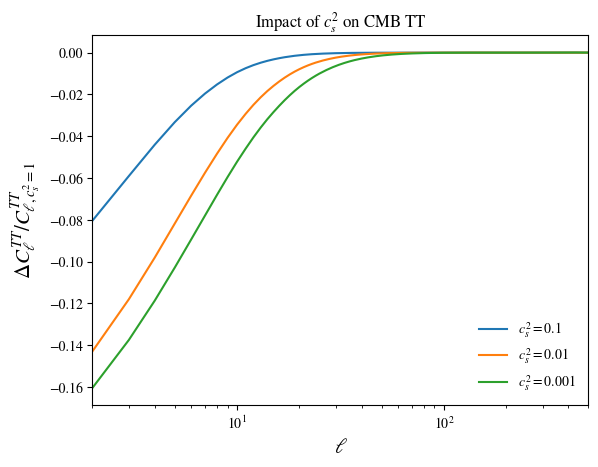

In [6]:
# Plot CMB C_\ell^TT
ells = np.arange(2051)
for case in cases:
    if case["name"] == "quint": continue
    plt.semilogx(ells, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])

plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$\Delta C_\ell^{TT}/C_{\ell, c_s^2=1}^{TT}$", fontsize=15)
plt.xlim([2, 500])
plt.legend()
plt.title("Impact of $c_s^2$ on CMB TT")
plt.savefig("cs2_impact_cl_tt.pdf")

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_30236/1900810665.py:14: SyntaxWarning: invalid escape sequence '\D'
  axs[0, 0].set_ylabel("$\Delta P(k)/P(k)_{c_s^2 = 1}$", fontsize=15)
/tmp/ipykernel_30236/1900810665.py:9: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].semilogx(ells_tt, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])
/tmp/ipykernel_30236/1900810665.py:10: RuntimeWarning: invalid value encountered in divide
  axs[1, 1].semilogx(ells_pp, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])


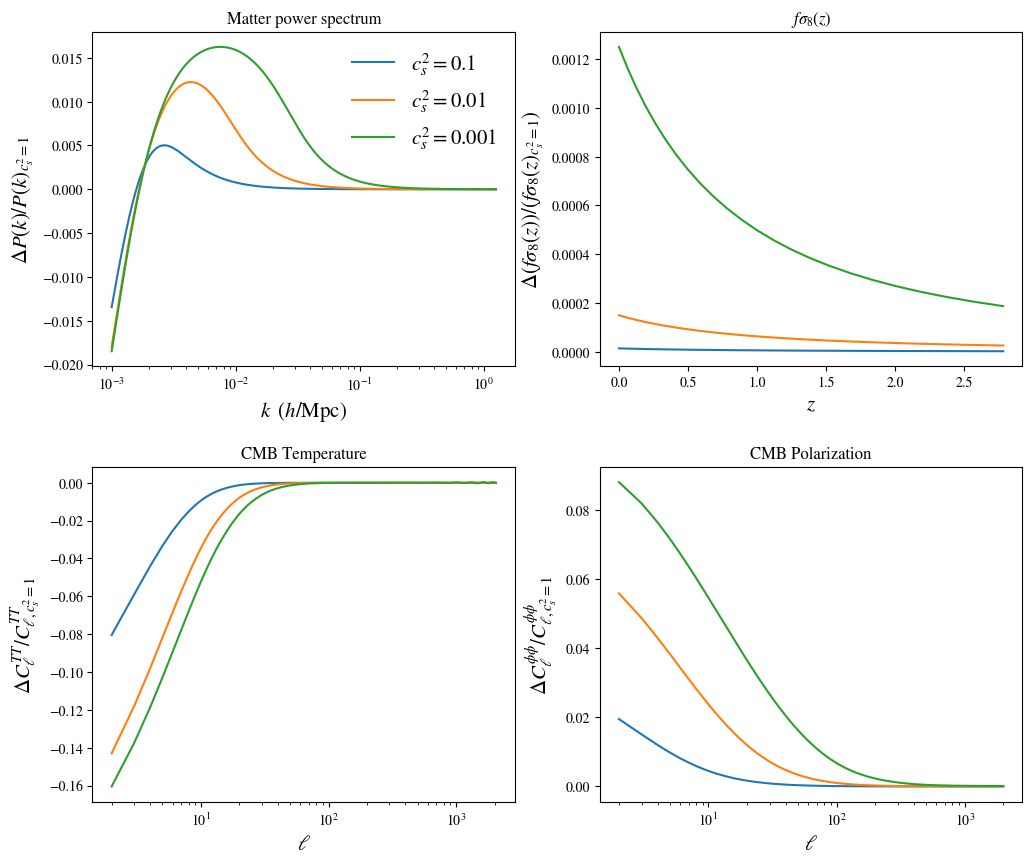

In [26]:
# Plot all
fig, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'hspace': 0.3})
ells_tt = np.arange(2051)
ells_pp = np.arange(2001)
for case in cases:
    if case["name"] == "quint": continue
    axs[0, 0].semilogx(ks, data[case["name"]]["P_lin"]/data["quint"]["P_lin"] - 1, label=case["label"])
    axs[0, 1].plot(redshifts[redshifts < 3], data[case["name"]]["fsigma8"][redshifts < 3]/data["quint"]["fsigma8"][redshifts < 3] - 1, label=case["label"])
    axs[1, 0].semilogx(ells_tt, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])
    axs[1, 1].semilogx(ells_pp, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])

axs[0, 0].set_title("Matter power spectrum")
axs[0, 0].set_xlabel("$k \\;\\; (h/\\mathrm{Mpc})$", fontsize=15)
axs[0, 0].set_ylabel("$\Delta P(k)/P(k)_{c_s^2 = 1}$", fontsize=15)
axs[0, 1].set_title("$f\\sigma_8(z)$")
axs[0, 1].set_xlabel("$z$", fontsize=15)
axs[0, 1].set_ylabel(r"$\Delta(f\sigma_8(z))/(f\sigma_8(z)_{c_s^2=1})$", fontsize=15)
axs[1, 0].set_title("CMB Temperature")
axs[1, 0].set_xlabel(r"$\ell$", fontsize=15)
axs[1, 0].set_ylabel(r"$\Delta C_\ell^{TT}/C_{\ell, c_s^2=1}^{TT}$", fontsize=15)
axs[1, 1].set_title("CMB Polarization")
axs[1, 1].set_xlabel(r"$\ell$", fontsize=15)
axs[1, 1].set_ylabel(r"$\Delta C_\ell^{\phi\phi}/C_{\ell, c_s^2=1}^{\phi\phi}$", fontsize=15)
axs[0, 0].legend(fontsize=15)
plt.savefig("cs2_impact_all.pdf")

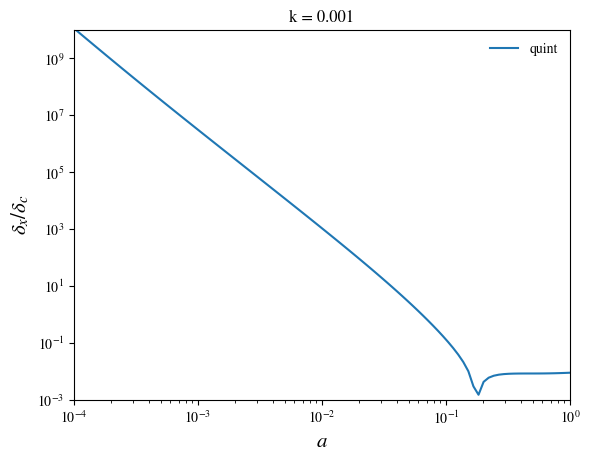

In [41]:
# Plot transfer function
# k_index = 199
for case in cases:
    plt.loglog(scale_factors, np.abs(data[case["name"]]["delta_de"][0]/data[case["name"]]["delta_cdm"][0]),  label=case["name"])
    break
    # plt.loglog(scale_factors, np.abs(data[case["name"]]["delta_de"][50])/np.abs(data[case["name"]]["delta_cdm"][50]),   label=f"$k = {ks[50]:.3f}$",  color="tab:red")
    # plt.loglog(scale_factors, np.abs(data[case["name"]]["delta_de"][100])/np.abs(data[case["name"]]["delta_cdm"][100]), label=f"$k = {ks[100]:.3f}$", color="tab:green")
    # plt.loglog(scale_factors, np.abs(data[case["name"]]["delta_de"][100])/np.abs(data[case["name"]]["delta_cdm"][150]), label=f"$k = {ks[150]:.3f}$", color="tab:purple")
# plt.title(f"k = {ks[k_index]}")
plt.title(f"k = {ks[0]}")
plt.xlabel("$a$", fontsize=15)
plt.xlim([1e-4, 1])
plt.ylim([1e-3, 1e10])
plt.ylabel(r"$\delta_x/\delta_c$", fontsize=15)
plt.legend()
plt.savefig("test.png")